In [1]:
%matplotlib inline
import scanpy as sc
import pandas as pd
import anndata
import os
import re
import numpy as np
import ete3
import scipy
import importlib
import importlib.util
spec = importlib.util.spec_from_file_location("ScanpyUtilsMT", os.path.expanduser("~/code/pollye/MTsc/utils/ScanpyUtilsMT.py"))
sc_utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(sc_utils)
sc.settings.cachedir='~/cache/'
sc.settings.figdir='~/figs/Choroid/'

In [2]:
basepath='/home/mt/Downloads/'
fileList=['E40_Choroid_Out','E50_choroid_Out','E65-2019A_HIPPOCAMPUS_CHOROID_Out','E65-2019B_HIPPOCAMPUS_CHOROID_Out','E90-2019_HIPPOCAMPUS_AND_CHOROID_Out','Mix11_Out']

In [3]:
multi=sc.read_h5ad(os.path.join(basepath,"MultiseqRaw.h5ad"))
multi.var_names_make_unique()
multi._inplace_subset_obs([x is not None for x in [re.search('[a-zA-Z]', x) for x in multi.obs['region']]])
multi.obs['region']=[re.sub('_A_|_B_','_',x) for x in multi.obs['region']]
multi._inplace_subset_obs([x is None for x in [re.search('nan|Doublet|Negative', x) for x in multi.obs['region']]])
multi.obs['region']=sc_utils.macaque_correct_regions(multi.obs['ActualRegion'])
multi.obs['batch_name']='MULTIseq'
multi.obs['timepoint']=multi.obs['tp']
print(multi)
multi._inplace_subset_obs(['Choroid' in x for x in multi.obs['ActualRegion']])

AnnData object with n_obs × n_vars = 31657 × 30807 
    obs: 'ActualRegion', 'tp', 'simpleregion', 'batch', 'region', 'batch_name', 'timepoint'
    var: 'gene_ids-0', 'feature_types-0', 'gene_ids-1', 'feature_types-1', 'gene_ids-2', 'feature_types-2', 'gene_ids-3', 'feature_types-3', 'gene_ids-4', 'feature_types-4'


In [4]:
adatas=[]
for f in fileList:
    print(f)
    adata = sc.read_10x_mtx(os.path.join(basepath,'macaque2018summaries',f,'outs/filtered_feature_bc_matrix'),cache=True)
    adata.obs.index=[re.sub("-1","",x) for x in adata.obs.index]
    adata.uns['name']=f
    adata.uns['name']=sc_utils.macaque_process_irregular_names(adata.uns['name'])
    adata.obs['batch_name']=str(adata.uns['name'])
    adata.obs['timepoint']=sc_utils.tp_format_macaque(adata.uns['name'])
    regionstring=sc_utils.region_format_macaque(adata.uns['name'])
    regionstring=regionstring.lower()
    adata.obs['region']=regionstring
    adatas.append(adata)

E40_Choroid_Out


Trying to set attribute `.uns` of view, making a copy.


E50_choroid_Out


Trying to set attribute `.uns` of view, making a copy.


E65-2019A_HIPPOCAMPUS_CHOROID_Out


Trying to set attribute `.uns` of view, making a copy.


E65-2019B_HIPPOCAMPUS_CHOROID_Out


Trying to set attribute `.uns` of view, making a copy.


E90-2019_HIPPOCAMPUS_AND_CHOROID_Out


Trying to set attribute `.uns` of view, making a copy.


Mix11_Out


Trying to set attribute `.uns` of view, making a copy.


In [5]:
adatas=[multi]+adatas
adata=anndata.AnnData.concatenate(*adatas)
adata.obs['region']=sc_utils.macaque_correct_regions(adata.obs['region'])

In [6]:
adata.raw=adata

In [7]:
adata.obs['region'].unique()

array(['choroid', '-2019a_hippocampus_choroid',
       '-2019b_hippocampus_choroid', 'hippocampus_and_choroid'],
      dtype=object)

In [8]:
#import matplotlib
#matplotlib.use( 'Qt5' )

... storing 'ActualRegion' as categorical
... storing 'batch_name' as categorical
... storing 'region' as categorical
... storing 'simpleregion' as categorical
... storing 'timepoint' as categorical
... storing 'tp' as categorical
... storing 'feature_types-0-0' as categorical
... storing 'feature_types-1-0' as categorical
... storing 'feature_types-2-0' as categorical
... storing 'feature_types-3-0' as categorical
... storing 'feature_types-4-0' as categorical
... storing 'feature_types-1' as categorical
... storing 'feature_types-2' as categorical
... storing 'feature_types-3' as categorical
... storing 'feature_types-4' as categorical
... storing 'feature_types-5' as categorical
... storing 'feature_types-6' as categorical


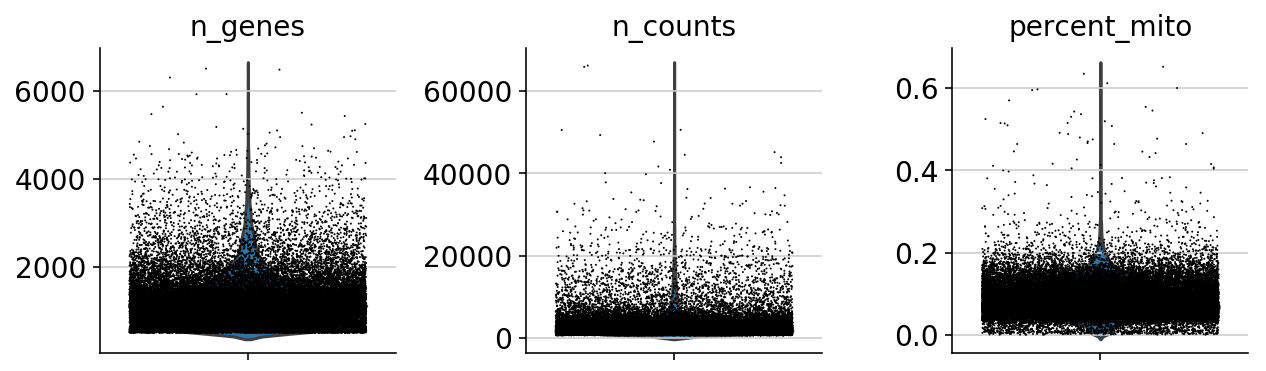

PCA
Neighbors


/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../utils/miniconda3/envs/pymc/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../utils/miniconda3/envs/pymc/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/home/mt/code/utils/miniconda3/envs/pymc/lib/p

UMAP
Leiden


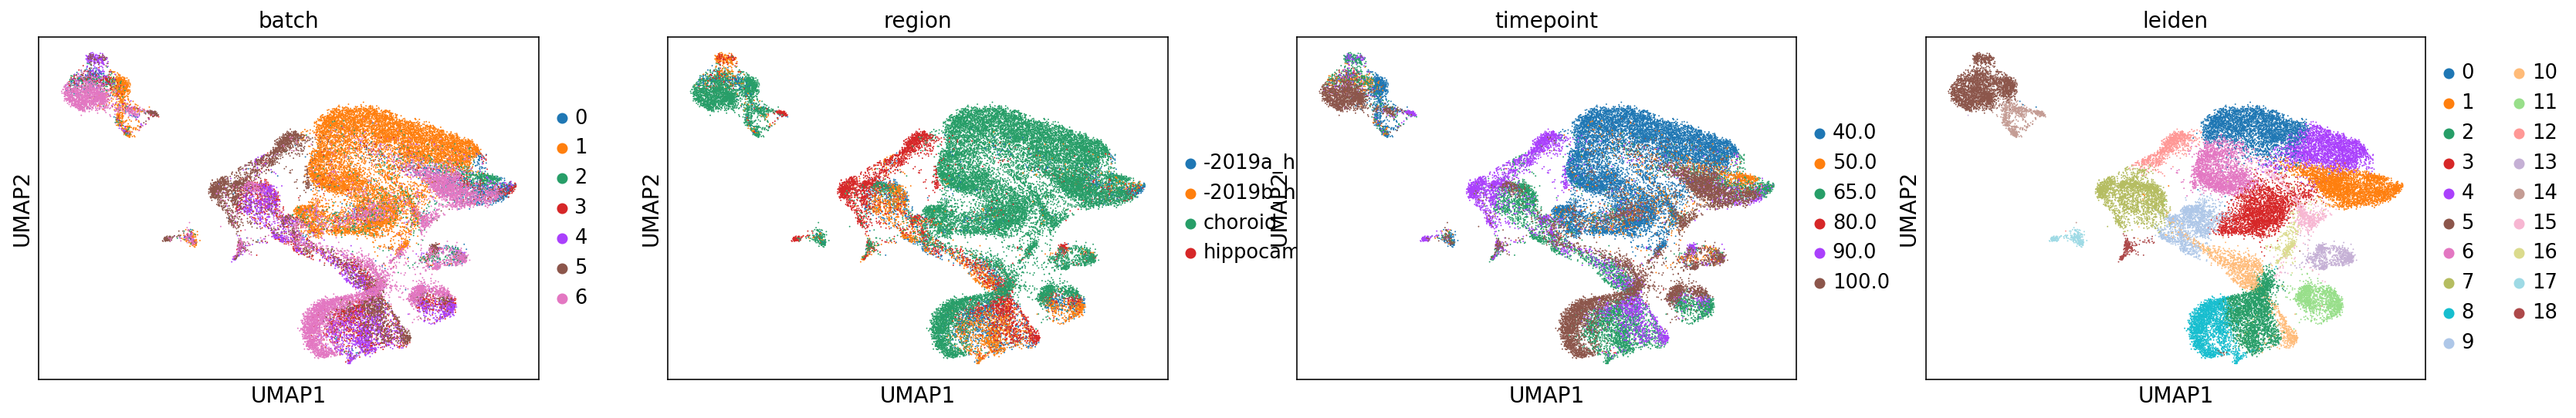

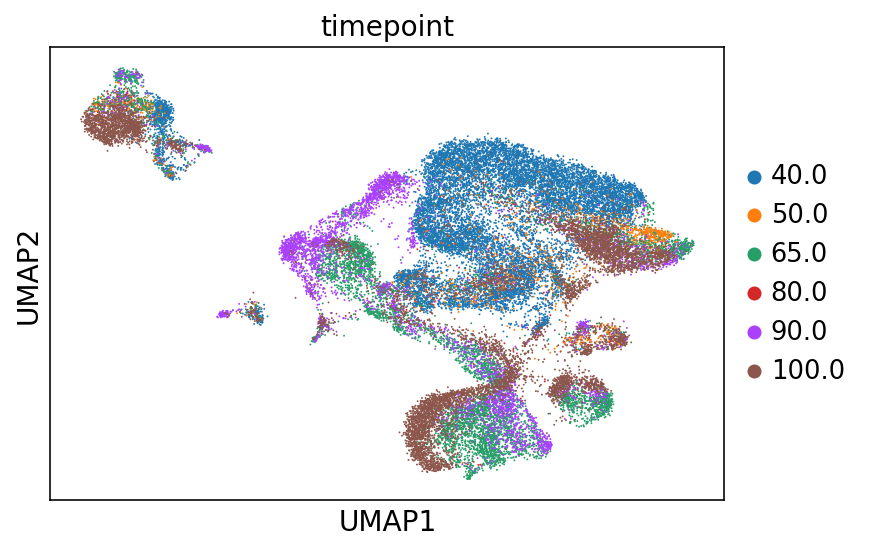

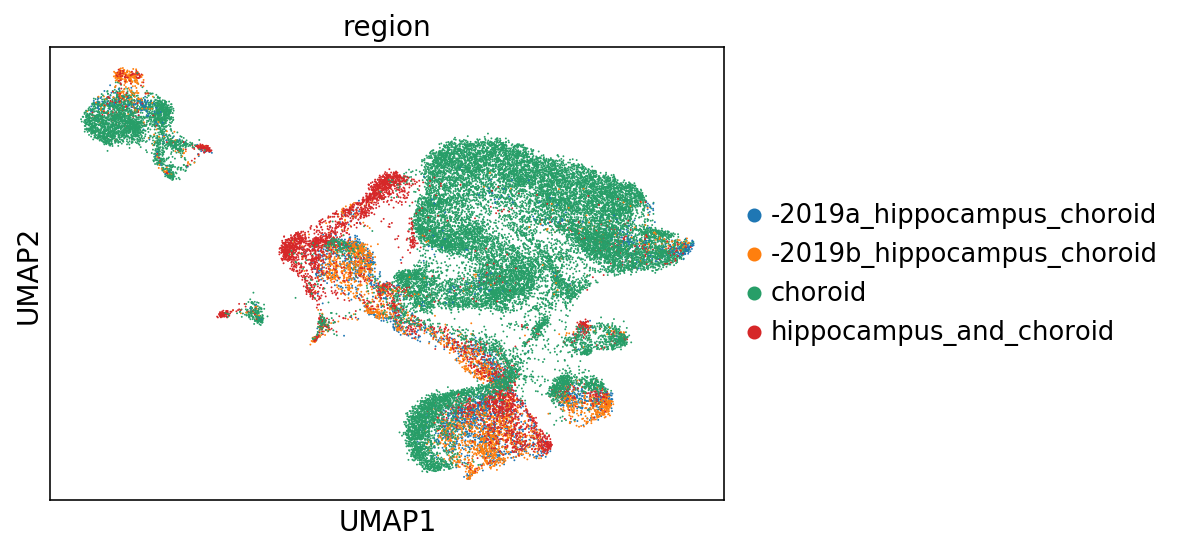

In [9]:
adata.var_names_make_unique()
mito_genes = [name for name in adata.var_names if name in ['ND1','ND2','ND4L','ND4','ND5','ND6','ATP6','ATP8','CYTB','COX1','COX2','COX3'] or 'MT-' in name]
ribo_genes = [name for name in adata.var_names if name.startswith('RPS') or name.startswith('RPL') ]
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['percent_ribo'] = np.sum(
    adata[:, ribo_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
sc.pp.filter_genes(adata, min_cells=20,inplace=True)
sc.pp.filter_cells(adata,min_genes=500)
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)


sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=5000)
sc.pp.scale(adata, max_value=10)
#sc.pp.regress_out(adata,'batch')

print("PCA", flush= True)
sc.pp.pca(adata)
print("Neighbors", flush= True)
import bbknn
bbknn.bbknn(adata,batch_key='batch')
#sc.pp.neighbors(adata)
print("UMAP", flush= True)
sc.tl.umap(adata)
print("Leiden", flush= True)
sc.tl.leiden(adata)

sc.pl.umap(adata,color=['batch','region','timepoint','leiden'])
sc.pl.umap(adata,color=['timepoint'])
sc.pl.umap(adata,color=['region'])


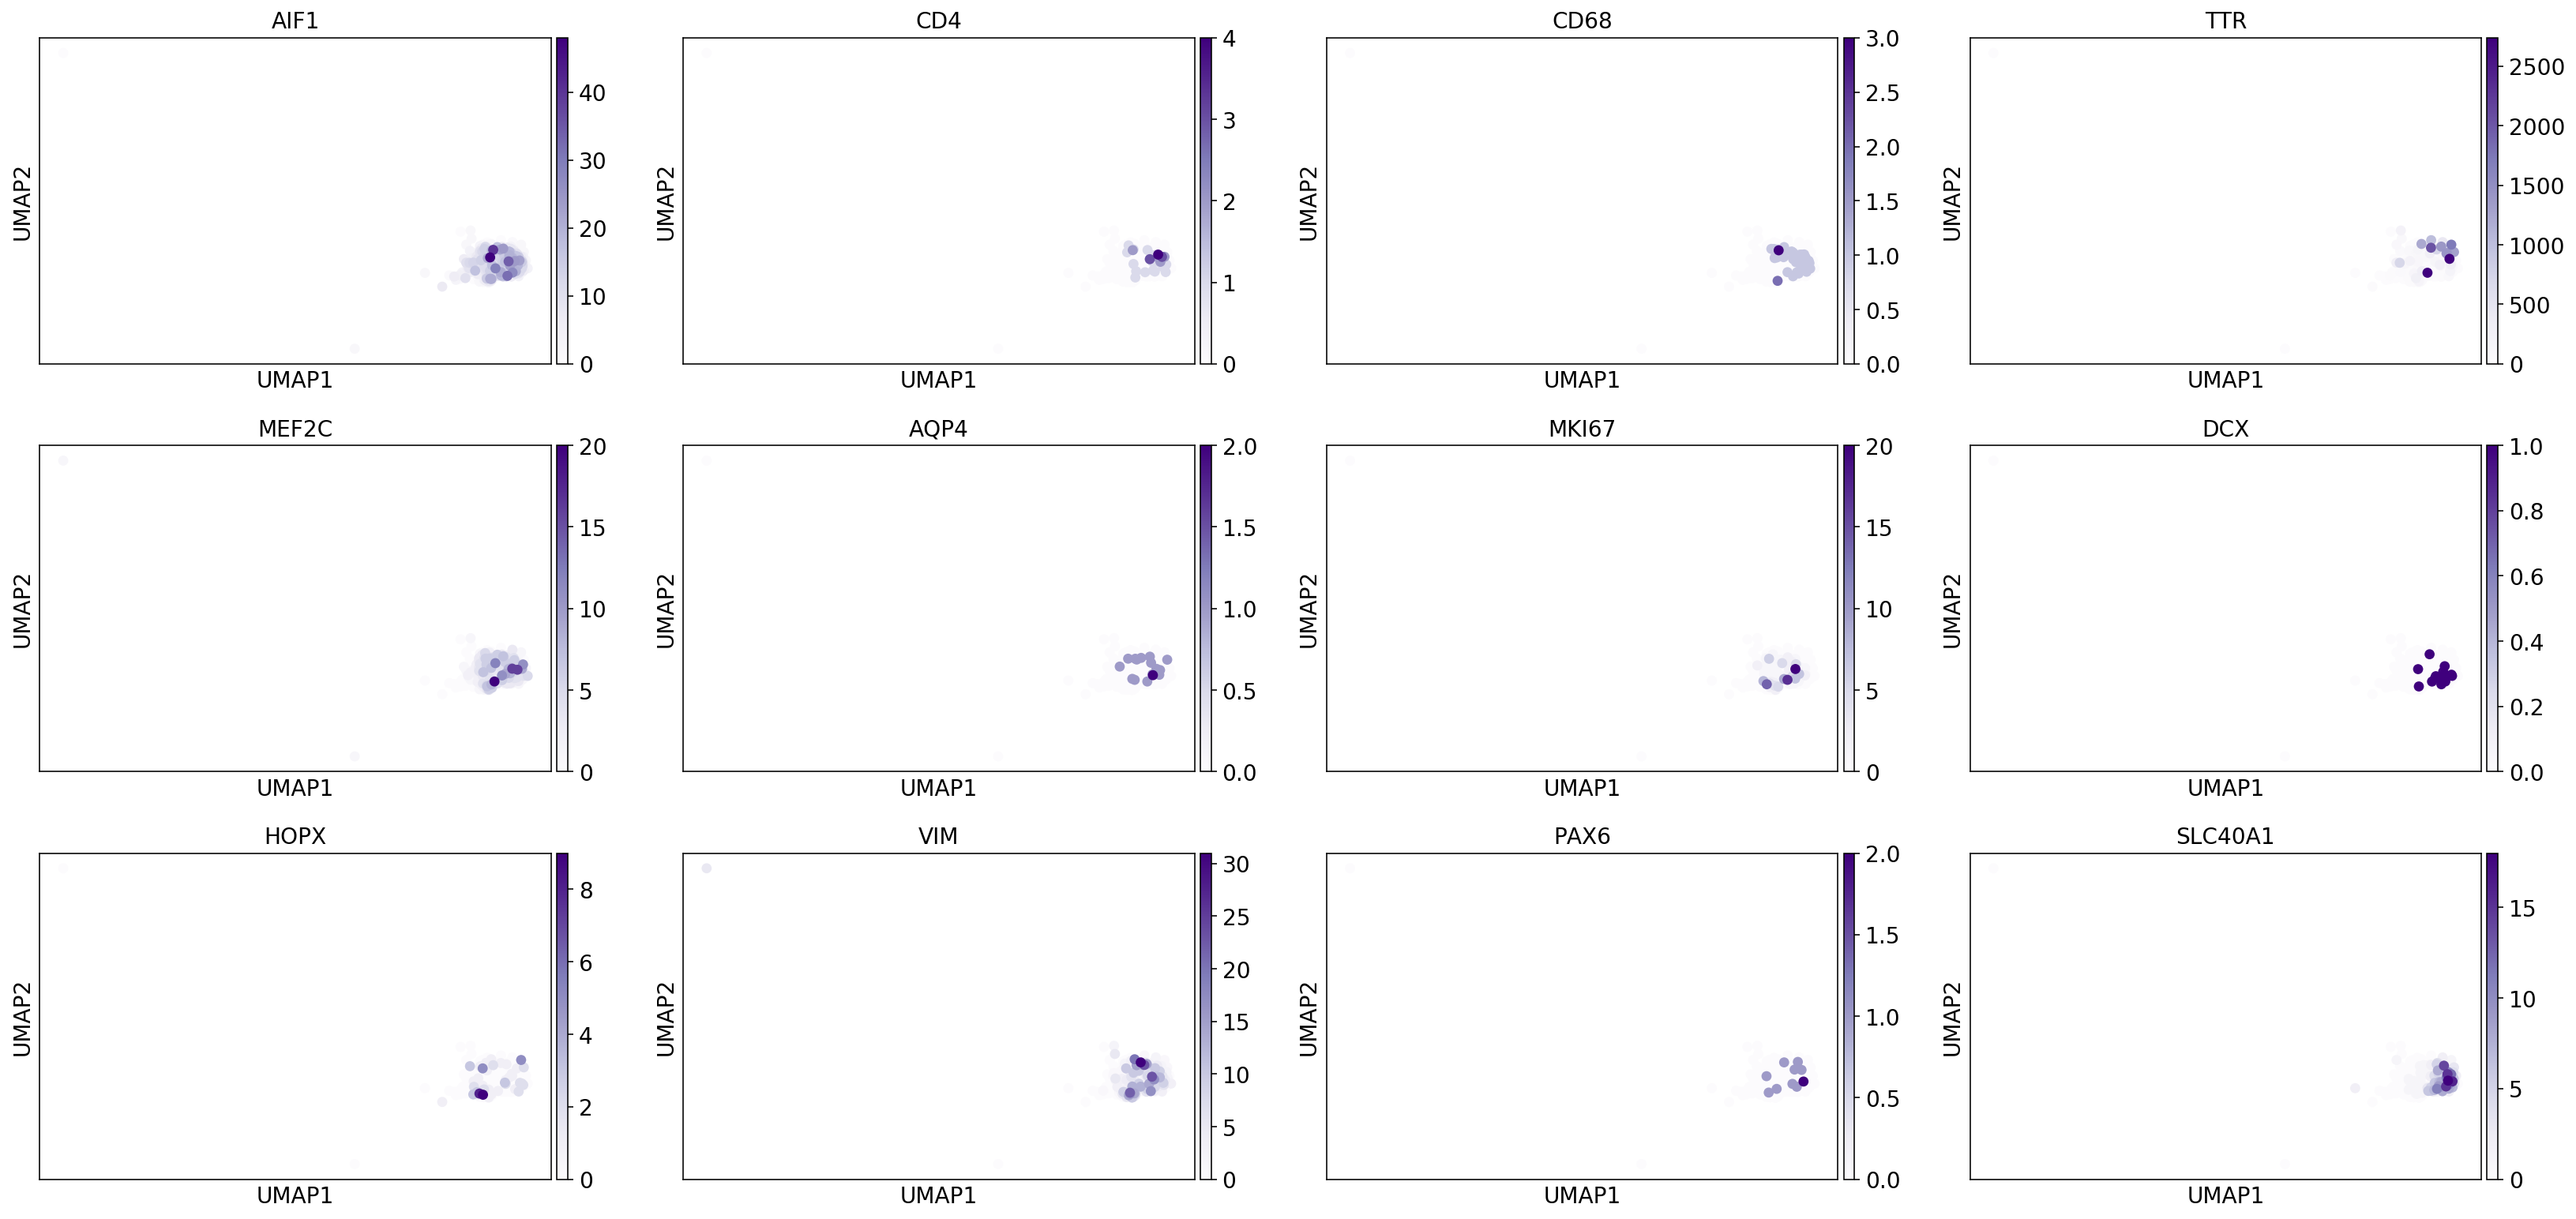

In [15]:
sc.pl.umap(adata,color=['AIF1','CD4','CD68','TTR','MEF2C','AQP4','MKI67','DCX','HOPX','VIM','PAX6','SLC40A1'])


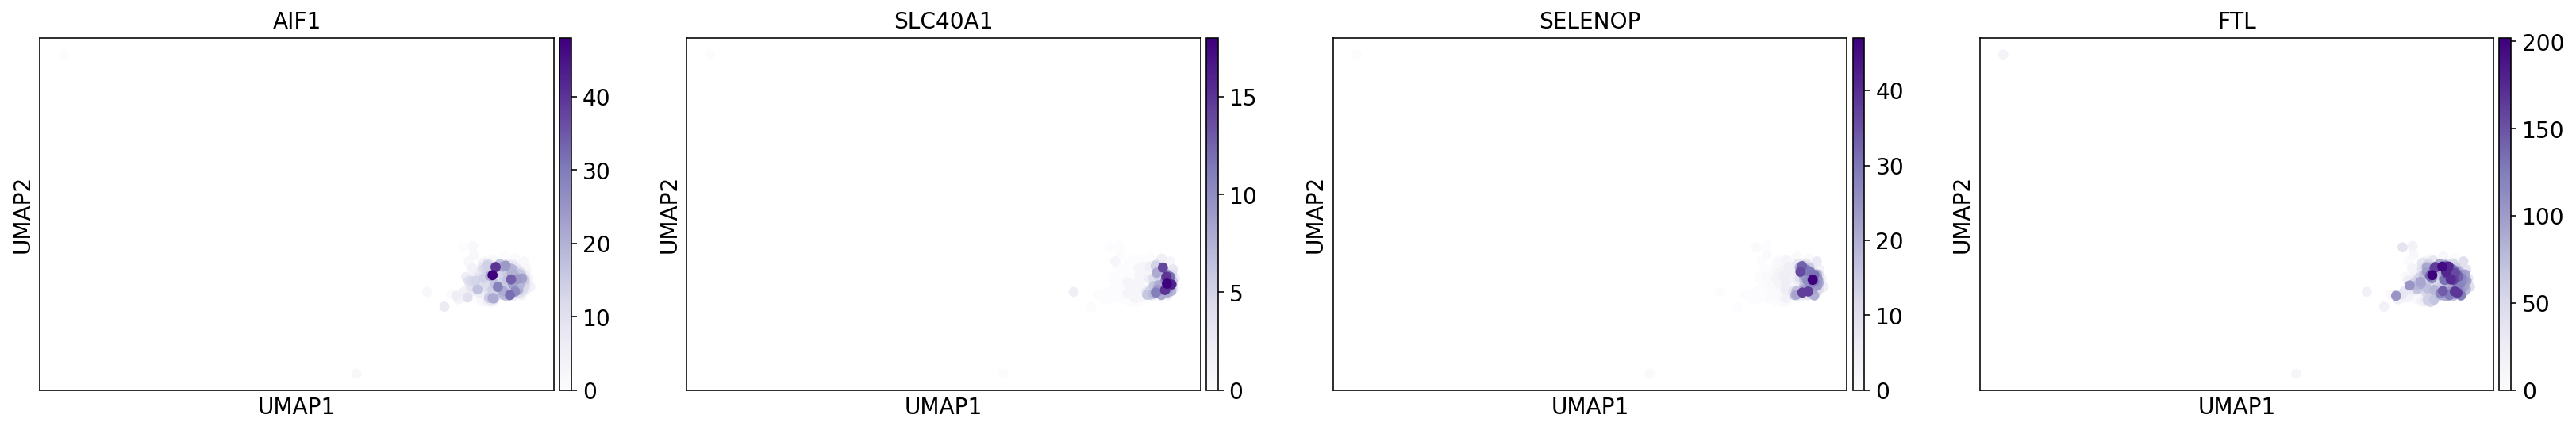

In [20]:
sc.pl.umap(adata,color=['AIF1','SLC40A1','SELENOP','FTL'])


In [12]:
adata._inplace_subset_obs(adata.obs['leiden']=='13')

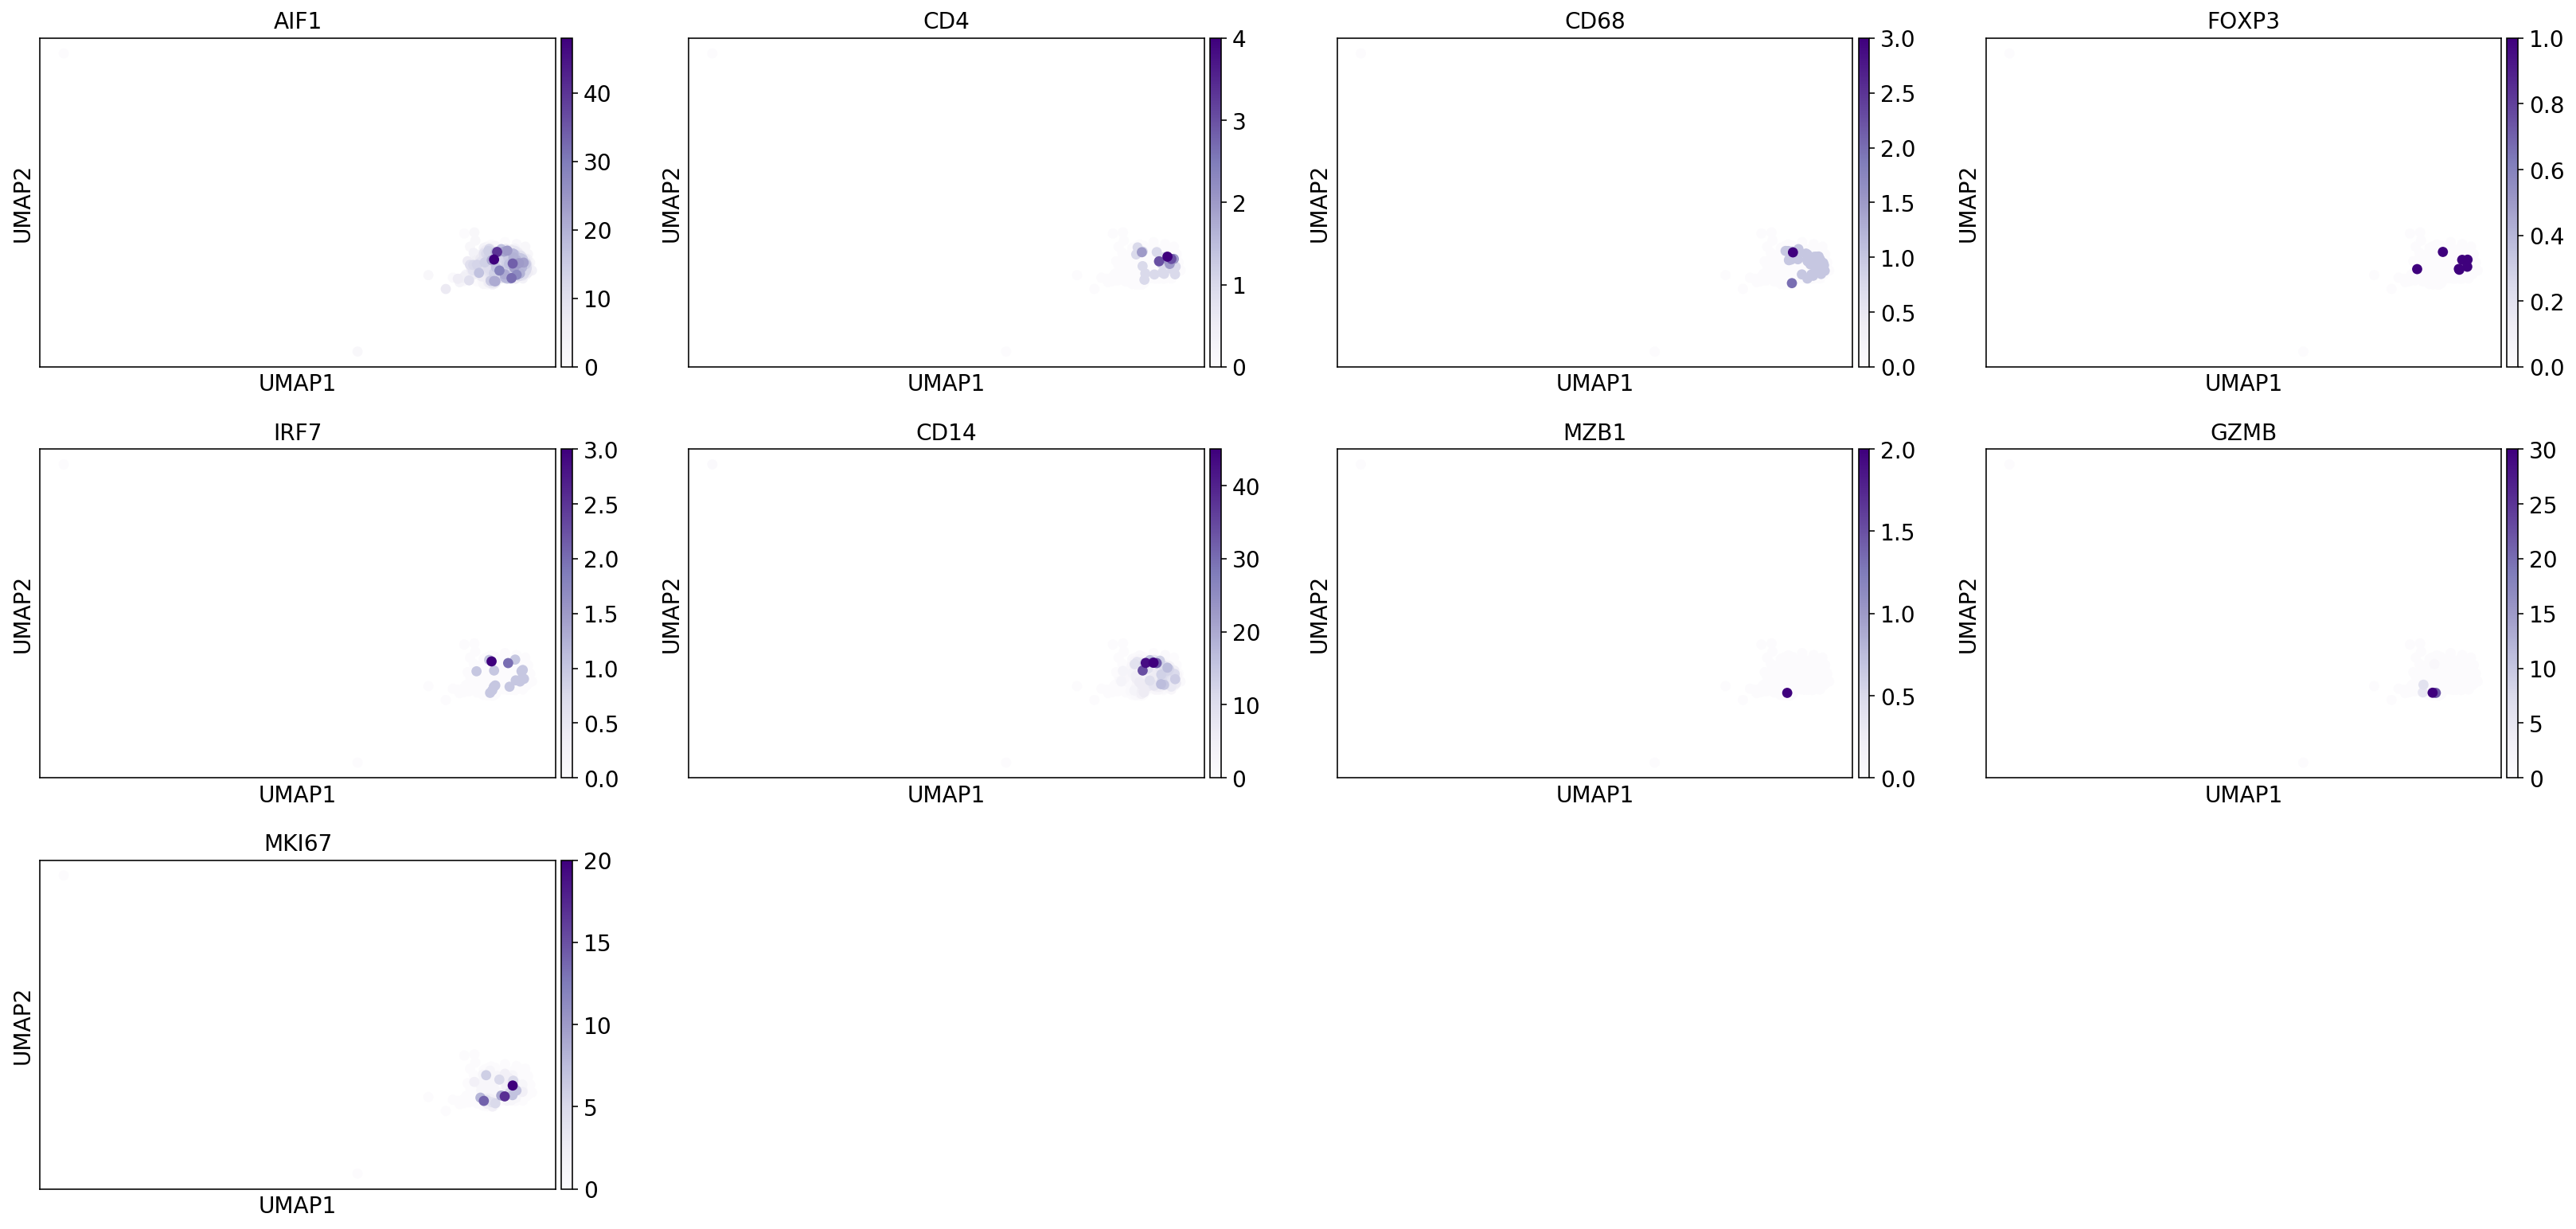

In [13]:
sc.pl.umap(adata,color=['AIF1','CD4','CD68','FOXP3','IRF7','CD14','MZB1','GZMB','MKI67'])

In [25]:
adata

AnnData object with n_obs × n_vars = 736 × 15921 
    obs: 'ActualRegion', 'batch', 'batch_name', 'region', 'simpleregion', 'timepoint', 'tp', 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'leiden'
    var: 'gene_ids-0-0', 'feature_types-0-0', 'gene_ids-1-0', 'feature_types-1-0', 'gene_ids-2-0', 'feature_types-2-0', 'gene_ids-3-0', 'feature_types-3-0', 'gene_ids-4-0', 'feature_types-4-0', 'gene_ids-1', 'feature_types-1', 'gene_ids-2', 'feature_types-2', 'gene_ids-3', 'feature_types-3', 'gene_ids-4', 'feature_types-4', 'gene_ids-5', 'feature_types-5', 'gene_ids-6', 'feature_types-6', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'leiden', 'batch_colors', 'region_colors', 'timepoint_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [ ]:
sc_utils.log_reg_diff_exp(adata)

In [4]:
adata=sc.read_h5ad('/home/mt/Downloads/figs/Choroid/microglia.h5ad')
clusterpca=[]
for c in adata.obs['leiden'].unique():
    print(c)
    a=adata.copy()
    a._inplace_subset_obs(a.obs['leiden']==c)
    clusterpca.append(a.obsm['X_pca'].mean(0))
clusterpca=np.array(clusterpca)
print(clusterpca)

from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

clusterpca=clusterpca[np.argsort([int(x)for x in adata.obs['leiden'].unique()]),:]

linked = linkage(clusterpca, 'average')

labelList = np.sort([int(x)for x in adata.obs['leiden'].unique()])

tree=scipy.cluster.hierarchy.to_tree(linked, rd=False)
def getAllDescendants(root):
    leftdescend=[]
    rightdescend=[]
    queue = [] 
    queue.append(root.left) 
    while(len(queue) > 0): 
        node = queue.pop(0) 
        if node.left is None and node.right is None:
            leftdescend.append(node.id)
        if node.left is not None: 
            queue.append(node.left) 
        if node.right is not None: 
            queue.append(node.right) 
    
    queue.append(root.right) 
    while(len(queue) > 0): 
        node = queue.pop(0) 
        if node.left is None and node.right is None:
            rightdescend.append(node.id)
        if node.left is not None: 
            queue.append(node.left) 
        if node.right is not None: 
            queue.append(node.right)
    return((leftdescend,rightdescend))

hierarchy=[]
queue = [] 
queue.append(tree) 
while(len(queue) > 0): 
    node = queue.pop(0) 
    if node.left is not None and node.right is not None:
        hierarchy.append([node.id,getAllDescendants(node)])
    if node.left.left is not None and node.left.right is not None: 
        queue.append(node.left) 
    if node.right.left is not None and node.right.right is not None: 
        queue.append(node.right) 


from collections import defaultdict
des=defaultdict()
for h in hierarchy:
    includeclusters=h[1][0]+h[1][1]
    a=adata.copy()
    a._inplace_subset_obs([int(x) in includeclusters for x in a.obs['leiden']])
    a.obs['clusters']=['left' if int(x) in h[1][0] else 'right' for x in a.obs['leiden'] ]
    sc.pp.highly_variable_genes(a, min_disp=1e-4)
    if(len(a.obs.clusters.unique())>1):
        sc.tl.rank_genes_groups(a, 'clusters', method='t-test_overestim_var',groups=['left','right'])
        result = a.uns['rank_genes_groups']
        groups = result['names'].dtype.names
        df=pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'scores']})
        des[str(h[0])]=(df['left_n'][0:6].tolist(),df['right_n'][0:6].tolist())


def getNewick(node, newick, parentdist, leaf_names):
    if node.is_leaf():
        return "%s:%.2f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
    else:
        if len(newick) > 0:
            newick = ")%s:%.2f%s" % (node.id,parentdist - node.dist, newick)
        else:
            newick = ");"
        newick = getNewick(node.get_left(), newick, node.dist, leaf_names)
        newick = getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
        newick = "(%s" % (newick)
        return newick
    
ts = ete3.TreeStyle()
ts.show_leaf_name = True
ts.show_branch_length = False
ts.show_branch_support = False

print(getNewick(tree, "", tree.dist, labelList))
t= ete3.Tree(getNewick(tree, "", tree.dist, labelList), format=1)
queue = [] 
queue.append(t) 
while(len(queue) > 0): 
    node = queue.pop(0)
    if node.name in des.keys():    
        node.children[1].add_face(ete3.TextFace(' '.join(des[node.name][0])), column=0, position="branch-bottom")
        node.children[0].add_face(ete3.TextFace(' '.join(des[node.name][1])), column=0, position="branch-top")
    if node.children is not None:
        for c in node.children:
            queue.append(c)
            
t.render("/home/mt/Downloads/HierarchicalCorrelationImmune.pdf", w=600, dpi=300, tree_style=ts)

2
0
4
3
7
6
5
1
8
[[-8.63205552e-01 -7.76229000e+00 -5.75451088e+00  1.15779960e+00
   1.41452885e+00  1.90058446e+00 -1.73056448e+00  2.57605672e+00
  -1.12824261e+00  1.20239627e+00  2.20405388e+00  7.53033161e-01
   3.99392918e-02 -2.16886967e-01 -2.29890376e-01  6.30966544e-01
  -2.96281248e-01 -4.94368643e-01 -1.70553043e-01 -8.94332305e-02
  -6.17160499e-01 -1.44361690e-01  1.12507708e-01  7.22265691e-02
   4.45605308e-01 -1.98886782e-01 -4.50859249e-01  9.59094986e-02
   3.00574638e-02  1.02617303e-02 -9.25451443e-02  2.98561633e-01
  -8.55508447e-02 -3.18388671e-01 -1.14938961e-02 -9.11527276e-02
  -4.14153904e-01 -1.90665424e-01 -4.62617517e-01  3.19725007e-01
  -3.35741967e-01  7.93992281e-02  2.12912410e-01  3.86037260e-01
   2.29131375e-02  3.04697543e-01  3.34509432e-01  1.14161439e-01
   2.90761087e-02  9.82008651e-02]
 [-5.17858601e+00  1.00496316e+00  3.64212728e+00 -6.34907627e+00
  -1.28081000e+00  1.15346706e+00  2.46255541e+00  2.16587305e+00
  -4.00218785e-01  7.17

... storing 'clusters' as categorical
/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:244: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))
/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:88: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
... storing 'clusters' as categorical
/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:244: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))
/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:88: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
... storing 'clusters' as categorical
/home/mt/c

((((((1:13.04,0:13.04)11:2.58,6:15.62)12:1.77,((5:11.66,4:11.66)9:1.27,2:12.93)10:4.46)13:4.56,7:21.95)14:1.82,3:23.77)15:20.57,8:44.33);


{'nodes': [[0.08843023763681856,
   83.99767197527304,
   0.7958721387313671,
   84.70511387636758,
   0,
   None],
  [15.387698982992434,
   72.04853611459792,
   16.095140884086984,
   72.75597801569248,
   1,
   None],
  [108.5931694521992,
   56.72799744401911,
   109.30061135329375,
   57.43543934511366,
   2,
   None],
  [211.52596606145602,
   37.75971147092153,
   212.23340796255056,
   38.46715337201608,
   3,
   None],
  [359.55818386549026,
   20.25052441883145,
   360.26562576658483,
   20.957966319926,
   4,
   None],
  [453.4710962357916,
   11.495930892786413,
   454.1785381368862,
   12.203372793880963,
   5,
   None],
  [583.2866850866412,
   5.659535208756388,
   583.9941269877359,
   6.366977109850937,
   6,
   None],
  [565.4237770840039,
   17.33232657681644,
   566.1312189850985,
   18.039768477910986,
   7,
   None],
  [498.03993600474814,
   29.00511794487649,
   498.7473779058427,
   29.712559845971036,
   8,
   None],
  [309.1529484125037,
   55.2688985230116,